In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
import holidays
import multiprocessing as mp
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score
import time


In [2]:
data = pd.read_csv('historical_data.csv')

In [24]:
data.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,...,%_dashers_avail,price_range,avg_item_price,price_volatility,order_intensity,delivery_difficulty,historical_avg_delivery_time,delivery_speed,log_subtotal,log_outstanding_orders
0,1.0,1845,4,1.0,4,3441,4,557,1239,33.0,...,0.297872,682,860.247849,0.792795,1.499999,1291.499078,62.983333,4.389079,8.143808,3.091042
1,2.0,5477,46,2.0,1,1900,1,1400,1400,1.0,...,0.666664,0,1899.981000,0.000000,0.999995,689.996550,59.158333,5.144198,7.550135,1.098612
2,3.0,5477,49,1.0,1,1900,1,1900,1900,1.0,...,0.000000,0,1899.981000,0.000000,0.000000,0.000000,34.008333,2.957244,7.550135,0.000010
4,3.0,5477,49,1.0,3,3900,3,1100,1600,6.0,...,0.500000,500,1299.995667,0.384617,1.499998,974.998375,33.116667,3.056920,8.268988,2.302585
5,3.0,5477,49,1.0,3,5000,3,1500,1900,2.0,...,0.499999,400,1666.661111,0.240001,0.999995,337.998310,34.008333,6.036972,8.517393,1.098612


In [3]:
# Convert datetime columns
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['delivery_duration_minutes'] = (
    (data['actual_delivery_time'] - data['created_at']).dt.total_seconds() / 60
)

# Time-Based Features
data['hour'] = data['created_at'].dt.hour
data['day_of_week_num'] = data['created_at'].dt.dayofweek
data['is_weekend'] = data['day_of_week_num'].isin([5, 6]).astype(int)

# Holiday Indicator
us_holidays = holidays.US()
data['is_holiday'] = data['created_at'].dt.date.astype(str).isin(us_holidays).astype(int)

# Dasher Features
data['total_busy_dashers'] = abs(data['total_busy_dashers'])  # Handle negative values
data['total_onshift_dashers'] = abs(data['total_onshift_dashers'])
data['dashers_per_order'] = data['total_onshift_dashers'] / (data['total_outstanding_orders'] + 1e-5)
data['%_dashers_avail'] = data['total_busy_dashers'] / (
    data['total_busy_dashers'] + data['total_onshift_dashers'] + 1e-5
)

# Price-Based Features
data['price_range'] = data['max_item_price'] - data['min_item_price']
data['avg_item_price'] = data['subtotal'] / (data['total_items'] + 1e-5)
data['price_volatility'] = data['price_range'] / (data['avg_item_price'] + 1e-5)

# Interaction Features
data['order_intensity'] = data['total_outstanding_orders'] / (data['total_busy_dashers'] + 1e-5)
data['delivery_difficulty'] = data['order_intensity'] * data['estimated_store_to_consumer_driving_duration']

# Delivery Speed
data['historical_avg_delivery_time'] = data.groupby(
    ['store_id', 'hour'])['delivery_duration_minutes'].transform('mean')
data['delivery_speed'] = data['historical_avg_delivery_time'] / (
    data['estimated_store_to_consumer_driving_duration'] / 60 + 1e-5)

# Log Transformations
data['log_subtotal'] = np.log1p(data['subtotal'])
data['log_outstanding_orders'] = np.log1p(data['total_outstanding_orders'].clip(lower=1e-5))

data = data.drop(columns=['created_at', 'actual_delivery_time'])

In [4]:
def remove_outliers_iqr(df, variables, threshold=1.5):

    for variable in variables:
        if variable in df.columns:
            Q1 = df[variable].quantile(0.25)
            Q3 = df[variable].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - (threshold * IQR)
            upper_bound = Q3 + (threshold * IQR)
            df = df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)]
    return df

outlier_columns = [
    'subtotal', 'delivery_duration_minutes', 'max_item_price', 'price_range',
    'avg_item_price', 'price_volatility', 'delivery_speed'
]
data = remove_outliers_iqr(data, outlier_columns)

In [5]:
def optimized_label_encoding(df, cat_cols):
    le_dict = {}

    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le

    return df, le_dict

categorical_columns = ['store_primary_category']
data, encoders = optimized_label_encoding(data, categorical_columns)

data['store_primary_category'].unique()

# drop na
data = data.dropna()

In [6]:
# Target and feature variables
X = data.drop(columns=['delivery_duration_minutes'])
y = data['delivery_duration_minutes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time
import multiprocessing as mp
from joblib import Parallel, delayed

# Function to train and evaluate a model
def train_evaluate_model(model_type, X_train, X_test, y_train, y_test):
    # Initialize the model based on model_type
    if model_type == 'linear':
        model = LinearRegression()
        model_name = 'Linear Regression'
    elif model_type == 'lasso':
        model = Lasso(alpha=0.1)
        model_name = 'Lasso'
    elif model_type == 'ridge':
        model = Ridge(alpha=0.1)
        model_name = 'Ridge'
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return {
        'model_name': model_name,
        'rmse': rmse,
        'r2': r2
    }

# Run models sequentially
def run_sequential(X_train, X_test, y_train, y_test):
    start_time = time.time()
    
    results = []
    model_types = ['linear', 'lasso', 'ridge']
    
    for model_type in model_types:
        result = train_evaluate_model(model_type, X_train, X_test, y_train, y_test)
        results.append(result)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    return results, execution_time

# Run models in parallel using joblib (easier than multiprocessing)
def run_parallel(X_train, X_test, y_train, y_test):
    start_time = time.time()
    
    model_types = ['linear', 'lasso', 'ridge']
    
    # Run the models in parallel using joblib
    results = Parallel(n_jobs=-1)(
        delayed(train_evaluate_model)(model_type, X_train, X_test, y_train, y_test) 
        for model_type in model_types
    )
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    return results, execution_time

# Compare sequential and parallel execution
def compare_execution(X_train, X_test, y_train, y_test):
    # Run models sequentially
    print("Running models sequentially...")
    sequential_results, sequential_time = run_sequential(X_train, X_test, y_train, y_test)
    
    # Run models in parallel
    print("Running models in parallel...")
    parallel_results, parallel_time = run_parallel(X_train, X_test, y_train, y_test)
    
    # Display results
    print("\n=== Model Performance ===")
    for result in sequential_results:
        print(f"{result['model_name']}: RMSE = {result['rmse']:.4f}, R² = {result['r2']:.4f}")
    
    # Compare execution times
    print("\n=== Execution Time Comparison ===")
    print(f"Sequential execution time: {sequential_time:.4f} seconds")
    print(f"Parallel execution time: {parallel_time:.4f} seconds")
    print(f"Speedup: {sequential_time / parallel_time:.2f}x")
    
    return sequential_results, parallel_results, sequential_time, parallel_time

# Only run this code in the main process
if __name__ == "__main__":
    # Assuming X_train, X_test, y_train, y_test are already defined
    compare_execution(X_train, X_test, y_train, y_test)

Running models sequentially...
Running models in parallel...
Running models in parallel...

=== Model Performance ===
Linear Regression: RMSE = 10.5841, R² = 0.4629
Lasso: RMSE = 10.6124, R² = 0.4600
Ridge: RMSE = 10.5841, R² = 0.4629

=== Execution Time Comparison ===
Sequential execution time: 0.3400 seconds
Parallel execution time: 1.8264 seconds
Speedup: 0.19x

=== Model Performance ===
Linear Regression: RMSE = 10.5841, R² = 0.4629
Lasso: RMSE = 10.6124, R² = 0.4600
Ridge: RMSE = 10.5841, R² = 0.4629

=== Execution Time Comparison ===
Sequential execution time: 0.3400 seconds
Parallel execution time: 1.8264 seconds
Speedup: 0.19x


In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import random
from joblib import Parallel, delayed

def train_with_random_features(seed_model_tuple, X_train, X_test, y_train, y_test, min_features=5, alpha=0.1):
    """
    Train a model with randomly selected features.
    
    Parameters:
    - seed_model_tuple: (seed, model_type) tuple
    - X_train, X_test, y_train, y_test: Training and testing data
    - min_features: Minimum number of features to select
    - alpha: Regularization parameter for Lasso and Ridge
    
    Returns:
    - Dictionary with model results and selected features
    """
    seed, model_type = seed_model_tuple
    
    # Set random seed
    np.random.seed(seed)
    
    # Get number of features
    n_features = X_train.shape[1]
    
    # Randomly select between min_features and n_features features
    n_selected = np.random.randint(min_features, n_features + 1)
    
    # Randomly select feature indices
    selected_indices = np.random.choice(n_features, size=n_selected, replace=False)
    
    # Select the features
    X_train_selected = X_train[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]
    
    # Initialize the appropriate model
    if model_type == 'linear':
        model = LinearRegression()
        model_name = 'Linear Regression'
    elif model_type == 'lasso':
        model = Lasso(alpha=alpha)
        model_name = 'Lasso Regression'
    elif model_type == 'ridge':
        model = Ridge(alpha=alpha)
        model_name = 'Ridge Regression'
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Train the model
    model.fit(X_train_selected, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_selected)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'seed': seed,
        'model_type': model_type,
        'model_name': model_name,
        'n_features': n_selected,
        'selected_indices': selected_indices,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

def run_sequential(X_train, X_test, y_train, y_test, n_permutations=100):
    """Run random feature selection sequentially for all model types."""
    start_time = time.time()
    
    results = []
    model_types = ['linear', 'lasso', 'ridge']
    
    for seed in range(n_permutations):
        for model_type in model_types:
            result = train_with_random_features((seed, model_type), X_train, X_test, y_train, y_test)
            results.append(result)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Find the best model (lowest RMSE)
    best_model = min(results, key=lambda x: x['rmse'])
    
    return results, best_model, execution_time

def run_parallel(X_train, X_test, y_train, y_test, n_permutations=100, n_jobs=-1):
    """Run random feature selection in parallel for all model types."""
    start_time = time.time()
    
    model_types = ['linear', 'lasso', 'ridge']
    # Create a list of (seed, model_type) tuples for all combinations
    seed_model_combinations = [(seed, model_type) for seed in range(n_permutations) for model_type in model_types]
    
    # Run in parallel using joblib
    results = Parallel(n_jobs=n_jobs)(
        delayed(train_with_random_features)(combo, X_train, X_test, y_train, y_test) 
        for combo in seed_model_combinations
    )
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Find the best model (lowest RMSE)
    best_model = min(results, key=lambda x: x['rmse'])
    
    return results, best_model, execution_time

def compare_execution(X_train, X_test, y_train, y_test, n_permutations=100):
    """Compare sequential and parallel execution."""
    print(f"Running {n_permutations} permutations of random feature selection for 3 model types...")
    
    # Run sequentially
    print("\nRunning sequentially...")
    seq_results, seq_best, seq_time = run_sequential(X_train, X_test, y_train, y_test, n_permutations)
    
    # Run in parallel
    print("\nRunning in parallel...")
    par_results, par_best, par_time = run_parallel(X_train, X_test, y_train, y_test, n_permutations)
    
    # Display results
    print("\n=== Best Model from Sequential Run ===")
    print(f"Model type: {seq_best['model_name']}")
    print(f"Number of features selected: {seq_best['n_features']} out of {X_train.shape[1]}")
    print(f"RMSE: {seq_best['rmse']:.4f}")
    print(f"MAE: {seq_best['mae']:.4f}")
    print(f"R²: {seq_best['r2']:.4f}")
    
    print("\n=== Best Model from Parallel Run ===")
    print(f"Model type: {par_best['model_name']}")
    print(f"Number of features selected: {par_best['n_features']} out of {X_train.shape[1]}")
    print(f"RMSE: {par_best['rmse']:.4f}")
    print(f"MAE: {par_best['mae']:.4f}")
    print(f"R²: {par_best['r2']:.4f}")
    
    # Compare execution times
    print("\n=== Execution Time Comparison ===")
    print(f"Sequential execution time: {seq_time:.4f} seconds")
    print(f"Parallel execution time: {par_time:.4f} seconds")
    print(f"Speedup: {seq_time / par_time:.2f}x")
    
    # Calculate statistics across all permutations by model type
    print("\n=== Metric Statistics by Model Type ===")
    
    for model_type in ['linear', 'lasso', 'ridge']:
        print(f"\n--- {model_type.capitalize()} Regression ---")
        
        # Sequential results for this model type
        model_seq_results = [r for r in seq_results if r['model_type'] == model_type]
        seq_rmse_vals = [result['rmse'] for result in model_seq_results]
        seq_mae_vals = [result['mae'] for result in model_seq_results]
        seq_r2_vals = [result['r2'] for result in model_seq_results]
        
        print("Sequential Runs:")
        print(f"RMSE - Mean: {np.mean(seq_rmse_vals):.4f}, Min: {np.min(seq_rmse_vals):.4f}, Max: {np.max(seq_rmse_vals):.4f}")
        print(f"MAE - Mean: {np.mean(seq_mae_vals):.4f}, Min: {np.min(seq_mae_vals):.4f}, Max: {np.max(seq_mae_vals):.4f}")
        print(f"R² - Mean: {np.mean(seq_r2_vals):.4f}, Min: {np.min(seq_r2_vals):.4f}, Max: {np.max(seq_r2_vals):.4f}")
        
        # Parallel results for this model type
        model_par_results = [r for r in par_results if r['model_type'] == model_type]
        par_rmse_vals = [result['rmse'] for result in model_par_results]
        par_mae_vals = [result['mae'] for result in model_par_results]
        par_r2_vals = [result['r2'] for result in model_par_results]
        
        print("\nParallel Runs:")
        print(f"RMSE - Mean: {np.mean(par_rmse_vals):.4f}, Min: {np.min(par_rmse_vals):.4f}, Max: {np.max(par_rmse_vals):.4f}")
        print(f"MAE - Mean: {np.mean(par_mae_vals):.4f}, Min: {np.min(par_mae_vals):.4f}, Max: {np.max(par_mae_vals):.4f}")
        print(f"R² - Mean: {np.mean(par_r2_vals):.4f}, Min: {np.min(par_r2_vals):.4f}, Max: {np.max(par_r2_vals):.4f}")
    
    # Find the best model for each model type
    best_models = {}
    for model_type in ['linear', 'lasso', 'ridge']:
        model_results = [r for r in par_results if r['model_type'] == model_type]
        best_models[model_type] = min(model_results, key=lambda x: x['rmse'])
    
    print("\n=== Best Model for Each Type ===")
    for model_type, model in best_models.items():
        print(f"\n{model['model_name']}:")
        print(f"Number of features: {model['n_features']} out of {X_train.shape[1]}")
        print(f"RMSE: {model['rmse']:.4f}")
        print(f"MAE: {model['mae']:.4f}")
        print(f"R²: {model['r2']:.4f}")
    
    return seq_best, par_best, seq_time, par_time, best_models

# Run the comparison (wrap with if __name__ == "__main__" to avoid multiprocessing issues)
if __name__ == "__main__":
    # Assuming X_train, X_test, y_train, y_test are already defined
    best_sequential, best_parallel, sequential_time, parallel_time, best_models_by_type = compare_execution(
        X_train, X_test, y_train, y_test, n_permutations=500
    )
    
    # Display feature importance for the overall best model
    print("\n=== Feature Importance for Best Overall Model ===")
    feature_indices = best_parallel['selected_indices']
    
    # If you have feature names, you can print them as well
    # Assuming a DataFrame was used earlier, you can get the feature names
    # For demonstration, we'll just use indices
    for i, idx in enumerate(feature_indices):
        print(f"Feature {idx}: Important feature in the best model")

Running 500 permutations of random feature selection for 3 model types...

Running sequentially...

Running in parallel...

Running in parallel...

=== Best Model from Sequential Run ===
Model type: Ridge Regression
Number of features selected: 26 out of 29
RMSE: 10.5833
MAE: 8.1334
R²: 0.4629

=== Best Model from Parallel Run ===
Model type: Ridge Regression
Number of features selected: 26 out of 29
RMSE: 10.5833
MAE: 8.1334
R²: 0.4629

=== Execution Time Comparison ===
Sequential execution time: 60.3038 seconds
Parallel execution time: 16.3375 seconds
Speedup: 3.69x

=== Metric Statistics by Model Type ===

--- Linear Regression ---
Sequential Runs:
RMSE - Mean: 11.8586, Min: 10.5834, Max: 14.3869
MAE - Mean: 9.2740, Min: 8.1333, Max: 11.5819
R² - Mean: 0.3181, Min: 0.0075, Max: 0.4629

Parallel Runs:
RMSE - Mean: 11.8586, Min: 10.5834, Max: 14.3869
MAE - Mean: 9.2740, Min: 8.1333, Max: 11.5819
R² - Mean: 0.3181, Min: 0.0075, Max: 0.4629

--- Lasso Regression ---
Sequential Runs:
RMS

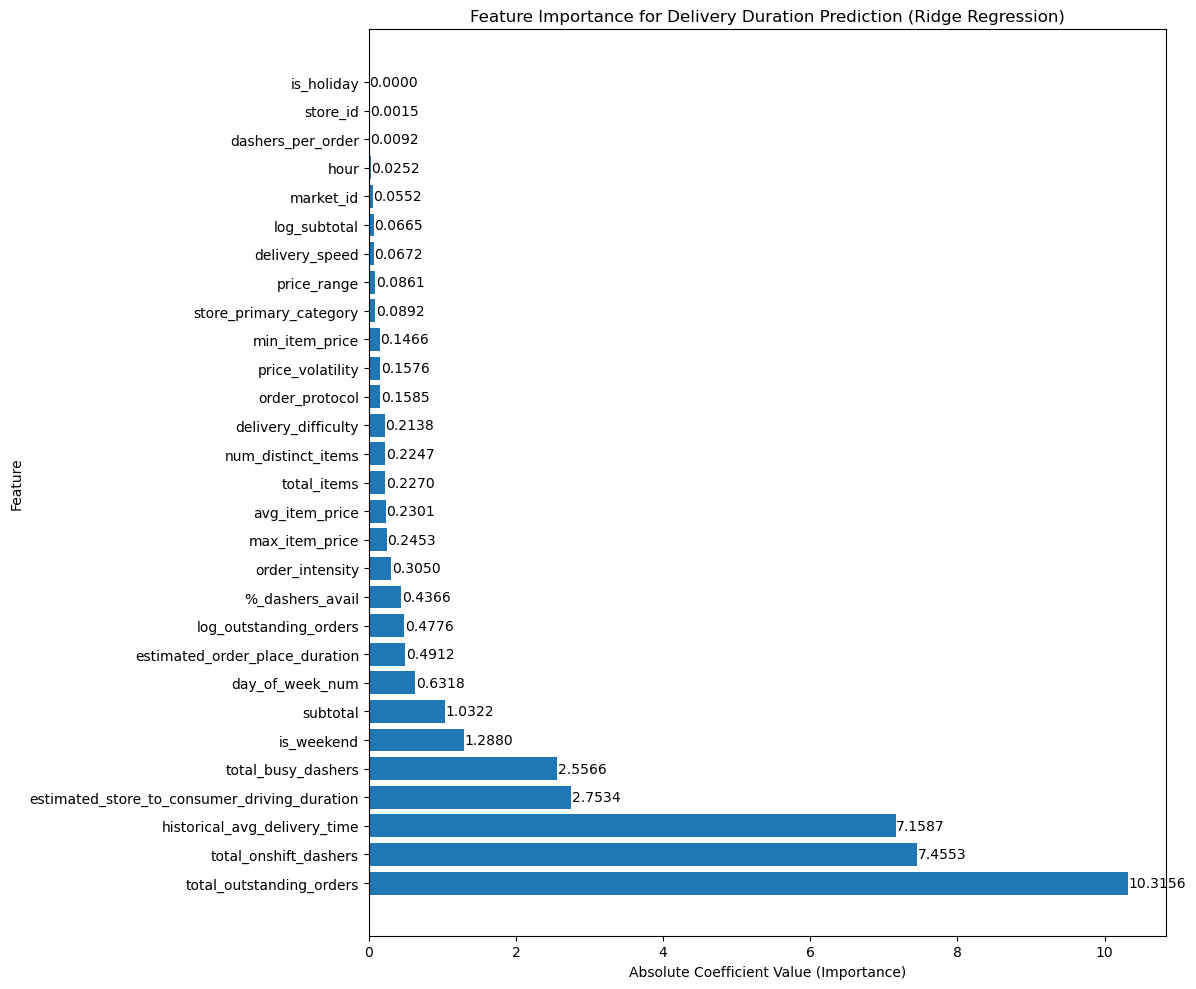

Top 10 most important features:
                                         Feature  Importance
11                      total_outstanding_orders   10.315631
9                          total_onshift_dashers    7.455286
25                  historical_avg_delivery_time    7.158661
13  estimated_store_to_consumer_driving_duration    2.753361
10                            total_busy_dashers    2.556573
16                                    is_weekend    1.287970
5                                       subtotal    1.032211
15                               day_of_week_num    0.631782
12                estimated_order_place_duration    0.491188
28                        log_outstanding_orders    0.477565


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge

# Assuming data, X_train, X_test, y_train, y_test are already defined from your notebook
# First, let's get the feature names from your original dataset
feature_names = data.drop(columns=['delivery_duration_minutes']).columns.tolist()

# Create and train the best model (Ridge Regression)
best_model = Ridge(alpha=0.1)
best_model.fit(X_train, y_train)

# Get feature importance from the model coefficients
# For Ridge regression, we can use the absolute value of coefficients
feature_importance = np.abs(best_model.coef_)

# Create a DataFrame to match feature names with their importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 10))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance for Delivery Duration Prediction (Ridge Regression)')

# Add importance values as text on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Print the top 10 most important features
print("Top 10 most important features:")
print(importance_df.head(10))